In [1]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from vision_transformer import vit_small

In [65]:
# Load your fine-tuned state_dict
checkpoint = torch.load('/Users/rohitpotdukhe/Documents/checkpoint0080.pth', map_location=torch.device('cpu'))

# Assuming checkpoint contains the keys 'student', 'teacher', 'early_stopping_epoch'
student_state_dict = checkpoint['student']

# Remove the 'backbone.' prefix from the state_dict keys
new_state_dict = {}
for key in student_state_dict.keys():
    new_key = key.replace('backbone.', '')
    new_state_dict[new_key] = student_state_dict[key]

# Load your model architecture
model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')

# Now load the modified state_dict
model.load_state_dict(new_state_dict, strict=False)

# Add the early_stopping_epoch attribute to your model if needed
model.early_stopping_epoch = checkpoint.get('early_stopping_epoch', None)

Using cache found in /Users/rohitpotdukhe/.cache/torch/hub/facebookresearch_dino_main


In [66]:
import os
import torch
from torchvision import datasets, transforms
import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn.metrics import accuracy_score, normalized_mutual_info_score, adjusted_rand_score
from sklearn.metrics.pairwise import cosine_similarity


from torch import threshold
# Define the transformations (this should be the same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Example resize, adjust to your needs
    transforms.ToTensor(),
    # Add the same normalization as used during training
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


test_dataset_dir = '/Users/rohitpotdukhe/Documents/val'

labeled_dataset = datasets.ImageFolder(test_dataset_dir, transform=transform)
labeled_loader = torch.utils.data.DataLoader(labeled_dataset, batch_size=32, shuffle=True)

# Initialize a list to store predictions
all_predictions = []

# Iterate over test dataset using DataLoader
for images, _ in labeled_loader:
    # Forward pass through the model
    with torch.no_grad():
        model.eval()
        outputs = model(images)

    # Append the predictions to the list
    all_predictions.append(outputs.cpu().numpy())

# Combine predictions into a single NumPy array
all_predictions = np.concatenate(all_predictions, axis=0)


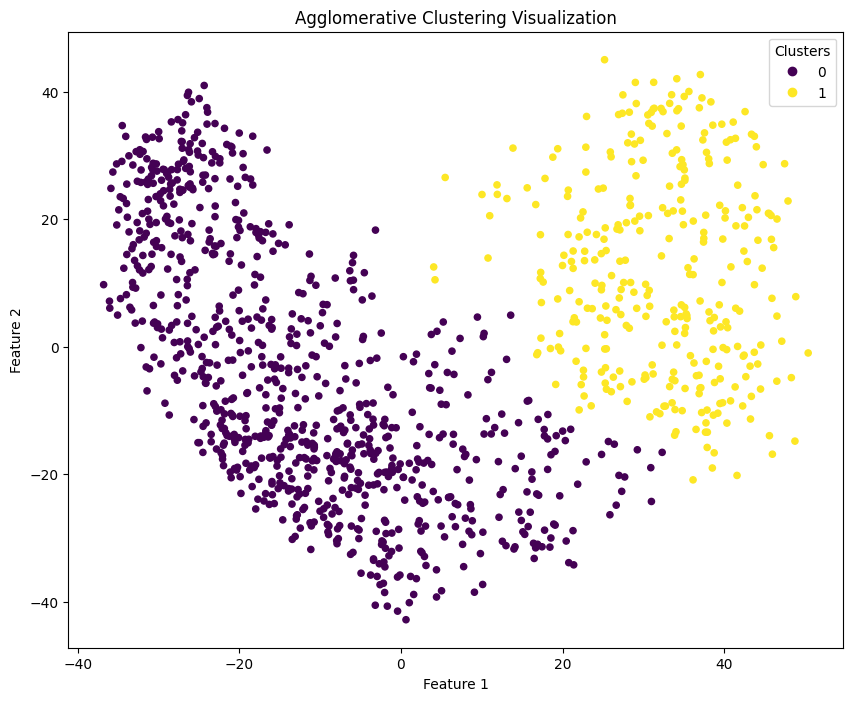

Accuracy: 0.5584970111016225
Normalized Mutual Information: 7.800371122965672e-06
Adjusted Rand Index: -0.001291783566726803


In [67]:
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(all_predictions)

# Create an Agglomerative Clustering model
n_clusters = 2  # You need to specify the number of clusters
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)

# Fit the clustering model to your data
cluster_labels = agg_clustering.fit_predict(reduced_features)

# Visualize the clusters
plt.figure(figsize=(10, 8))

# Scatter plot of the cluster representations in 2D
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap='viridis', s=20)

# Customize the plot
plt.title('Agglomerative Clustering Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.show()

# Assuming you have ground truth labels for your test dataset
# Replace 'true_labels' with the actual ground truth labels
true_labels = labeled_dataset.targets

# Evaluate the clustering performance
accuracy = accuracy_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print(f"Accuracy: {accuracy}")
print(f"Normalized Mutual Information: {nmi}")
print(f"Adjusted Rand Index: {ari}")

In [73]:
print(student_state_dict.keys())

dict_keys(['module.backbone.cls_token', 'module.backbone.pos_embed', 'module.backbone.patch_embed.proj.weight', 'module.backbone.patch_embed.proj.bias', 'module.backbone.blocks.0.norm1.weight', 'module.backbone.blocks.0.norm1.bias', 'module.backbone.blocks.0.attn.qkv.weight', 'module.backbone.blocks.0.attn.qkv.bias', 'module.backbone.blocks.0.attn.proj.weight', 'module.backbone.blocks.0.attn.proj.bias', 'module.backbone.blocks.0.norm2.weight', 'module.backbone.blocks.0.norm2.bias', 'module.backbone.blocks.0.mlp.fc1.weight', 'module.backbone.blocks.0.mlp.fc1.bias', 'module.backbone.blocks.0.mlp.fc2.weight', 'module.backbone.blocks.0.mlp.fc2.bias', 'module.backbone.blocks.1.norm1.weight', 'module.backbone.blocks.1.norm1.bias', 'module.backbone.blocks.1.attn.qkv.weight', 'module.backbone.blocks.1.attn.qkv.bias', 'module.backbone.blocks.1.attn.proj.weight', 'module.backbone.blocks.1.attn.proj.bias', 'module.backbone.blocks.1.norm2.weight', 'module.backbone.blocks.1.norm2.bias', 'module.bac

In [74]:
print(new_state_dict.keys())

dict_keys(['module.cls_token', 'module.pos_embed', 'module.patch_embed.proj.weight', 'module.patch_embed.proj.bias', 'module.blocks.0.norm1.weight', 'module.blocks.0.norm1.bias', 'module.blocks.0.attn.qkv.weight', 'module.blocks.0.attn.qkv.bias', 'module.blocks.0.attn.proj.weight', 'module.blocks.0.attn.proj.bias', 'module.blocks.0.norm2.weight', 'module.blocks.0.norm2.bias', 'module.blocks.0.mlp.fc1.weight', 'module.blocks.0.mlp.fc1.bias', 'module.blocks.0.mlp.fc2.weight', 'module.blocks.0.mlp.fc2.bias', 'module.blocks.1.norm1.weight', 'module.blocks.1.norm1.bias', 'module.blocks.1.attn.qkv.weight', 'module.blocks.1.attn.qkv.bias', 'module.blocks.1.attn.proj.weight', 'module.blocks.1.attn.proj.bias', 'module.blocks.1.norm2.weight', 'module.blocks.1.norm2.bias', 'module.blocks.1.mlp.fc1.weight', 'module.blocks.1.mlp.fc1.bias', 'module.blocks.1.mlp.fc2.weight', 'module.blocks.1.mlp.fc2.bias', 'module.blocks.2.norm1.weight', 'module.blocks.2.norm1.bias', 'module.blocks.2.attn.qkv.weight'

In [72]:
model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
print(model.__dict__.keys())

Using cache found in /Users/rohitpotdukhe/.cache/torch/hub/facebookresearch_dino_main


dict_keys(['training', '_parameters', '_buffers', '_non_persistent_buffers_set', '_backward_pre_hooks', '_backward_hooks', '_is_full_backward_hook', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_hooks_always_called', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_state_dict_hooks', '_state_dict_pre_hooks', '_load_state_dict_pre_hooks', '_load_state_dict_post_hooks', '_modules', 'num_features', 'embed_dim'])


In [45]:
checkpoint = torch.load('/Users/rohitpotdukhe/Documents/checkpoint0080.pth', map_location=torch.device('cpu'))
print(checkpoint.keys())

dict_keys(['student', 'teacher', 'optimizer', 'epoch', 'args', 'dino_loss', 'fp16_scaler'])


In [71]:
import torch
from torchvision import datasets, transforms
from PIL import Image
from eval_linear import LinearClassifier

# Define a custom dataset class
class ImageTestDataset(torch.utils.data.Dataset):
  def __init__(self, root_dir, transform=None):
    # root_dir is the path to the folder that contains the subfolders FC and NG
    # transform is an optional torchvision transform that can be applied to the images
    self.root_dir = root_dir
    self.transform = transform
    # Use the datasets.ImageFolder method to load the images and the labels from the subfolders
    # The labels will be 0 for FC and 1 for NG
    self.dataset = datasets.ImageFolder(root_dir, transform=transform)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  def __len__(self):
    # Return the number of images in the dataset
    return len(self.dataset)

  def __getitem__(self, idx):
    # Return the image tensor and the label for the given index
    return self.dataset[idx]

# Create a data loader
# Define a transform that can resize and normalize the images
transform = transforms.Compose([
  transforms.Resize(224), # Resize the images to 224x224
  transforms.ToTensor(), # Convert the images to tensors
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalize the images using ImageNet statistics
])

# Create an instance of the dataset class
dataset = ImageTestDataset(root_dir='/Users/rohitpotdukhe/Documents/val', transform=transform)

# Create a data loader that can batch and shuffle the dataset
# You can adjust the batch size according to your memory
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Load the pretrained model and the fine-tuned checkpoint
# Load the backbone
model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
# Load the linear classifier
linear_classifier = LinearClassifier(1536, 2) # 2 is the number of classes (good or bad)
# Load the fine-tuned checkpoint
checkpoint = torch.load('/Users/rohitpotdukhe/Documents/checkpoint0080.pth', map_location=torch.device('cpu'))
# Load the state dictionary for the backbone and the linear classifier
#model.load_state_dict(checkpoint["student"])
model.load_state_dict(new_state_dict, strict=False)
linear_classifier.load_state_dict(checkpoint["linear"])

# Define a function that can compute the accuracy of the model on the test data
def compute_accuracy(model, linear_classifier, data_loader):
  # Set the model and the linear classifier to evaluation mode
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.eval()
  linear_classifier.eval()
  # Initialize the accuracy to zero
  accuracy = 0
  # Loop over the data loader
  for images, labels in data_loader:
    # Move the images and the labels to the device (cpu or cuda)
    images = images.to(device)
    labels = labels.to(device)
    # Get the output features from the model
    with torch.no_grad():
      output = model(images)
    # Pass the output features to the linear classifier
    output = linear_classifier(output)
    # Get the predictions by taking the argmax of the output
    predictions = torch.argmax(output, dim=1)
    # Compare the predictions with the labels and update the accuracy
    accuracy += torch.sum(predictions == labels).item()
  # Return the accuracy as a percentage
  return accuracy / len(data_loader.dataset) * 100

# Compute the accuracy of the model on the test data
accuracy = compute_accuracy(model, linear_classifier, data_loader)
# Print the accuracy
print(f"Accuracy of the model on the test data: {accuracy:.2f}%")


Using cache found in /Users/rohitpotdukhe/.cache/torch/hub/facebookresearch_dino_main


KeyError: 'linear'

In [78]:
checkpoint_test = torch.load('/Users/rohitpotdukhe/Documents/checkpoint0080.pth', map_location=torch.device('cpu'))
student_state_dict_test = checkpoint_test['student']
print(student_state_dict_test.keys())

msg = student_state_dict_test.load_state_dict(checkpoint_test['student'], strict=False)

odict_keys(['module.backbone.cls_token', 'module.backbone.pos_embed', 'module.backbone.patch_embed.proj.weight', 'module.backbone.patch_embed.proj.bias', 'module.backbone.blocks.0.norm1.weight', 'module.backbone.blocks.0.norm1.bias', 'module.backbone.blocks.0.attn.qkv.weight', 'module.backbone.blocks.0.attn.qkv.bias', 'module.backbone.blocks.0.attn.proj.weight', 'module.backbone.blocks.0.attn.proj.bias', 'module.backbone.blocks.0.norm2.weight', 'module.backbone.blocks.0.norm2.bias', 'module.backbone.blocks.0.mlp.fc1.weight', 'module.backbone.blocks.0.mlp.fc1.bias', 'module.backbone.blocks.0.mlp.fc2.weight', 'module.backbone.blocks.0.mlp.fc2.bias', 'module.backbone.blocks.1.norm1.weight', 'module.backbone.blocks.1.norm1.bias', 'module.backbone.blocks.1.attn.qkv.weight', 'module.backbone.blocks.1.attn.qkv.bias', 'module.backbone.blocks.1.attn.proj.weight', 'module.backbone.blocks.1.attn.proj.bias', 'module.backbone.blocks.1.norm2.weight', 'module.backbone.blocks.1.norm2.bias', 'module.ba

AttributeError: 'collections.OrderedDict' object has no attribute 'load_state_dict'

In [79]:
from transformers import ViTModel
model_test = ViTModel.from_pretrained('facebook/dino-vits16', add_pooling_layer=False)

config.json: 100%|██████████| 453/453 [00:00<00:00, 3.97MB/s]
pytorch_model.bin: 100%|██████████| 86.7M/86.7M [00:30<00:00, 2.83MB/s]


In [80]:
print(model_test.__dict__.keys())

dict_keys(['training', '_parameters', '_buffers', '_non_persistent_buffers_set', '_backward_pre_hooks', '_backward_hooks', '_is_full_backward_hook', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_hooks_always_called', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_state_dict_hooks', '_state_dict_pre_hooks', '_load_state_dict_pre_hooks', '_load_state_dict_post_hooks', '_modules', 'config', 'name_or_path', 'warnings_issued', 'generation_config', '_keep_in_fp32_modules', 'pooler', '_is_hf_initialized', 'is_loaded_in_4bit', 'is_loaded_in_8bit'])
